# Курсовой проект курса "Рекомендательные системы"

- Для обучения доступны 95 недель + информация о пользователях и товарах
- 96 - 98 недели недоступны. Нужно предсказать какие товары пользователи купят за эти 3 недели
- Качество оценивается по метрике **precision@5**, усредненной по всем пользователям. 
- Критерий сдачи: значение метрики > 0.27
- Во время разработки модели выделите 3 известные недели (93 - 95) в качестве валидационной выборки. Продемонстрируйте на валидационной выборке требуемое значение precision@5
- Ноутбук должен содержать описание pipeline’а Вашей модели. (Какие модели использовали, какие признаки генерировали и тд)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [4]:
# Рестарт/реимпорт подключаемых модулей при их изменении в Jupyter notebook 
# import os
# os.chdir('C:/Users/Alex/YandexDisk/it/gb/rec_sys/src')
# %run utils.py

**Загрузка данных**

In [5]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

**Обработка столбцов**

In [6]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

Важна схема обучения и валидации!

-- давние покупки -- | -- 6 недель -- | -- 3 недели -- 

подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

In [7]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


**Появление новых пользователей на валидационной и тестовой выборках**

In [8]:
users_lvl_1 = data_train_lvl_1.user_id.unique()
users_lvl_2 = data_val_lvl_1.user_id.unique()
users_lvl_3 = data_val_lvl_2.user_id.unique()

new_users_lvl_2 = list(set(users_lvl_2) - set(users_lvl_1))
new_users_lvl_3 = list(set(users_lvl_3) - (set(users_lvl_1) | set(users_lvl_2)))

add_to_lvl_2 = list(set(users_lvl_3) - (set(users_lvl_2)))

print('Количество пользователей в интервале до 6 нед:', new_users_lvl_2)
print('Количество новых пользователей в интервале 6 нед:', new_users_lvl_3)
print('Количество новых пользователей в интервале 3 нед:', len(add_to_lvl_2))

Количество пользователей в интервале до 6 нед: [1984]
Количество новых пользователей в интервале 6 нед: []
Количество новых пользователей в интервале 3 нед: 126


## Обзор датасета

In [9]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [10]:
data.shape

(2396804, 12)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [12]:
data.describe().style.set_precision(0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2387280842.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.describe().style.set_precision(0)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2396804,2396804,2396804,2396804,2396804,2396804,2396804,2396804,2396804,2396804,2396804,2396804
mean,1272,33366432676,364,2827247,100,3,3048,-1,1562,53,-0,-0
std,727,4284798176,176,3732798,1152,4,8786,1,402,25,0,0
min,1,26984851472,1,25671,0,0,1,-130,0,1,-56,-8
25%,655,30087143433,216,916993,1,1,330,-1,1307,32,0,0
50%,1271,32419978306,366,1027569,1,2,370,-0,1614,53,0,0
75%,1914,35145801967,515,1132178,1,3,422,0,1844,74,0,0
max,2500,41656790510,663,18024556,89638,840,34280,4,2359,95,0,0


In [13]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [14]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


**Количество уникальных значений**

In [15]:
data.nunique()

user_id                2499
basket_id            257001
day                     663
item_id               89051
quantity              11246
sales_value            5435
store_id                573
retail_disc            2364
trans_time             1440
week_no                  95
coupon_disc             393
coupon_match_disc        79
dtype: int64

In [16]:
item_features.nunique()

item_id                 92353
manufacturer             6476
department                 44
brand                       2
commodity_desc            308
sub_commodity_desc       2383
curr_size_of_product     4345
dtype: int64

In [17]:
user_features.nunique()

age_desc                 6
marital_status_code      3
income_desc             12
homeowner_desc           5
hh_comp_desc             6
household_size_desc      5
kid_category_desc        4
user_id                801
dtype: int64

## Обзор категориальных переменных

In [18]:
item_features['department'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

**Категориальные переменные фичей пользователей**

In [19]:
for column in user_features.columns[:-1]:
    print(column, ':', user_features[column].unique(), '\n')

age_desc : ['65+' '45-54' '25-34' '35-44' '19-24' '55-64'] 

marital_status_code : ['A' 'U' 'B'] 

income_desc : ['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K'] 

homeowner_desc : ['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner'] 

hh_comp_desc : ['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids'] 

household_size_desc : ['2' '3' '4' '1' '5+'] 

kid_category_desc : ['None/Unknown' '1' '2' '3+'] 



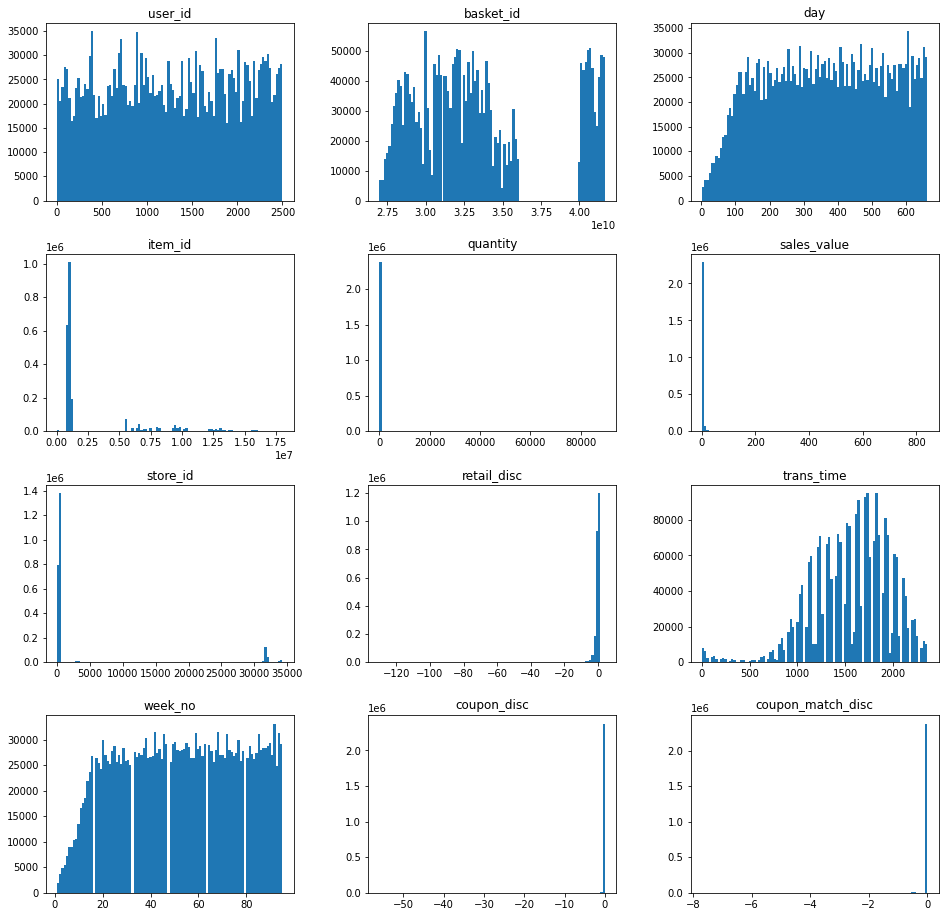

In [20]:
data.hist(figsize=(16,16), bins=100, grid=False);

## Обучение модели ALS

**Количество уникальных items и user до и после префильтрации data_train_lvl_1**

In [21]:
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [22]:
user_features.nunique()

age_desc                 6
marital_status_code      3
income_desc             12
homeowner_desc           5
hh_comp_desc             6
household_size_desc      5
kid_category_desc        4
user_id                801
dtype: int64

**Перекодируем признаки**

In [23]:
user_features['age_desc'].replace(
    {'19-24': 22, '25-34': 30, '35-44': 40, '45-54': 50, '55-64': 60, '65+': 70},
    inplace=True)

user_features['marital_status_code'].replace(
    {'U': 0, 'A': 1, 'B': 2}, inplace=True)

user_features['income_desc'].replace(
    {'Under 15K': 10, '15-24K': 20, '25-34K':30, '35-49K': 40,
     '50-74K': 62, '75-99K': 87, '100-124K': 112, '125-149K': 137, 
     '150-174K': 162, '175-199K': 187, '200-249K': 225, '250K+':275}, inplace=True)

user_features['homeowner_desc'].replace(
    {'Unknown': 0, 'Probable Renter': 1, 'Renter': 2,
     'Probable Owner': 3, 'Homeowner': 4}, inplace=True)

user_features['hh_comp_desc'].replace(
    {'Unknown': 0, 'Single Male': 1, 'Single Female': 2,
     '1 Adult Kids': 3, '2 Adults No Kids': 4, '2 Adults Kids':5},inplace=True)

user_features['household_size_desc'].replace({'5+': 5}, inplace=True) 

user_features['kid_category_desc'].replace(
    {'None/Unknown': 0, '3+': 3}, inplace=True)

user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,70,1,40,4,4,2,0,1
1,50,1,62,4,4,2,0,7


In [24]:
# names = ['manufacturer', 'department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product']
# for name in names:
#     new_name = name + '_freq'
#     a = item_features[name].value_counts()
#     ind = a.index.tolist()
#     for i in ind:
#         item_features.loc[item_features[name] == i, new_name] = a[i]

# item_features['brand'] = np.where(item_features['brand']=='Private', 0, 1)

# commodities = item_features.commodity_desc.value_counts()
# commodities_list = commodities.keys().tolist()
# for i, name in enumerate(commodities_list):
#     item_features.loc[item_features['commodity_desc'] == name, 'commodity_category'] = i

# item_features.head(2)

**Новые признаки пользователей и товаров на основе матрицы транзакций**

In [25]:
def get_user_item_features(data_train_lvl_1):
    # час совершения транзакции
    X = data_train_lvl_1.copy()
    X['hour'] = X['trans_time'] // 100
    user_item_features = X.groupby(['user_id', 'item_id'])['hour'].median().reset_index()
    user_item_features.columns = ['user_id', 'item_id', 'median_sales_hour']
    
    # день недели совершения транзакции
    X['weekday'] = X['day'] % 7
    df = X.groupby(['user_id', 'item_id'])['weekday'].median().reset_index()
    df.columns = ['user_id', 'item_id', 'median_weekday']
    user_item_features = user_item_features.merge(df, on=['user_id', 'item_id'])
    
    # cреднее кол-во дней между покупками
    df = X.groupby('user_id')['day'].nunique().reset_index()
    df['mean_visits_interval'] = (X.groupby('user_id')['day'].max() - X.groupby('user_id')['day'].min()) / df['day']
    user_item_features = user_item_features.merge(df[['user_id', 'mean_visits_interval']], on=['user_id'])
    
    # средний чек корзины клиента
    df = X.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
    df = df.groupby('user_id')['sales_value'].mean().reset_index()
    df.columns = ['user_id', 'mean_check']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # кол-во магазинов, в которых продавался товар
    df = X.groupby(['item_id'])['store_id'].nunique().reset_index()
    df.columns = ['item_id', 'n_stores']
    user_item_features = user_item_features.merge(df, on=['item_id'])
    
    # кол-во уникальных товаров, купленных клиентом
    df = X.groupby(['user_id'])['item_id'].nunique().reset_index()
    df.columns = ['user_id', 'n_items']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # кол-во транзакций клиента
    df = X.groupby(['user_id'])['item_id'].count().reset_index()
    df.columns = ['user_id', 'n_transactions']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # mean / max / std кол-ва уникальных товаров в корзине клиента
    df = X.groupby(['user_id', 'basket_id'])['item_id'].nunique().reset_index()
    df1 = df.groupby('user_id')['item_id'].mean().reset_index()
    df1.columns = ['user_id', 'mean_n_items_basket']
    user_item_features = user_item_features.merge(df1, on=['user_id'])

    df2 = df.groupby('user_id')['item_id'].max().reset_index()
    df2.columns = ['user_id', 'max_n_items_basket']
    user_item_features = user_item_features.merge(df2, on=['user_id'])

    df3 = df.groupby('user_id')['item_id'].std().reset_index()
    df3.columns = ['user_id', 'std_n_items_basket']
    user_item_features = user_item_features.merge(df3, on=['user_id'])
    
    # mean / max / std кол-ва уникальных категорий в корзине клиента
#     X = X.merge(item_features[['item_id', 'commodity_desc']], on=['item_id'])
#     df = X.groupby(['user_id', 'basket_id'])['commodity_desc'].nunique().reset_index()
#     df1 = df.groupby('user_id')['commodity_desc'].mean().reset_index()
#     df1.columns = ['user_id', 'mean_n_item_categories_basket']
#     user_item_features = user_item_features.merge(df1, on=['user_id'])

#     df2 = df.groupby('user_id')['commodity_desc'].max().reset_index()
#     df2.columns = ['user_id', 'max_n_item_categories_basket']
#     user_item_features = user_item_features.merge(df2, on=['user_id'])

#     df3 = df.groupby('user_id')['commodity_desc'].std().reset_index()
#     df3.columns = ['user_id', 'std_n_item_categories_basket']
#     user_item_features = user_item_features.merge(df3, on=['user_id'])
    
    # эмбеддинги товаров
    recommender = MainRecommender(X)
    df = recommender.model.item_factors
    n_factors = recommender.model.factors
    ind = list(recommender.id_to_itemid.values())
    df = pd.DataFrame(df, index=ind).reset_index()
    df.columns = ['item_id'] + ['factor_' + str(i + 1) for i in range(n_factors)]
    user_item_features = user_item_features.merge(df, on=['item_id'])
    
    # эмбеддинги пользователей
    df = recommender.model.user_factors
    ind = list(recommender.id_to_userid.values())
    df = pd.DataFrame(df, index=ind).reset_index()
    df.columns = ['user_id'] + ['user_factor_' + str(i + 1) for i in range(n_factors)]
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    return user_item_features

In [26]:
user_item_features = get_user_item_features(data_train_lvl_1)
user_item_features.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2495 [00:00<?, ?it/s]

,user_id,item_id,median_sales_hour,median_weekday,mean_visits_interval,mean_check,n_stores,n_items,n_transactions,mean_n_items_basket,...,user_factor_11,user_factor_12,user_factor_13,user_factor_14,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,user_factor_20
0,1,823721,13.0,4.0,NaN,37.4205,94,172,661,8.533333,...,-4.670919,10.429152,-14.31954,-1.452905,6.52488,-11.241791,13.060196,0.961446,-5.571281,16.617987
1,1,823990,15.0,6.0,NaN,37.4205,95,172,661,8.533333,...,-4.670919,10.429152,-14.31954,-1.452905,6.52488,-11.241791,13.060196,0.961446,-5.571281,16.617987


## Формирование признаков для обучения модели второго уровня

In [27]:
def get_candidates(data_train_lvl_1, data_train_lvl_2, N, add_to_lvl_2):
    recommender = MainRecommender(data_train_lvl_1)

    users_lvl_1 = data_train_lvl_1['user_id'].unique()
    users_lvl_2 = data_train_lvl_2['user_id'].unique().tolist()
    if add_to_lvl_2:
        users_lvl_2 += add_to_lvl_2

    current_users = list(set(users_lvl_2) & set(users_lvl_1))    
    new_users = list(set(users_lvl_2) - set(users_lvl_1))

    df = pd.DataFrame(users_lvl_2, columns=['user_id'])
    cond_1 = df['user_id'].isin(current_users)
    df.loc[cond_1, 'candidates'] = df.loc[cond_1, 'user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N))

    if new_users:
        cond_2 = df['user_id'].isin(new_users)
        df.loc[cond_2, 'candidates'] = df.loc[cond_2, 'user_id'].apply(
            lambda x: recommender.overall_top_purchases[:N])
        
    return df



def get_targets_lvl_2(data_train_lvl_1, data_train_lvl_2, user_item_features, N, add_to_lvl_2=None):
    
    users_lvl_2 = get_candidates(data_train_lvl_1, data_train_lvl_2, N, add_to_lvl_2)
    
    df = pd.DataFrame({'user_id': users_lvl_2['user_id'].values.repeat(N),
                       'item_id': np.concatenate(users_lvl_2['candidates'].values)})

    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
    targets_lvl_2['target'].fillna(0, inplace= True)
    
    #targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    #targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(
        user_item_features, on=['user_id', 'item_id'], how='left')
    
    return targets_lvl_2

In [ ]:
N = 500
targets_lvl_2 = get_targets_lvl_2(data_train_lvl_1, data_train_lvl_2, user_item_features, N, add_to_lvl_2)

print(f'число пользователей: {targets_lvl_2.user_id.nunique()}')
print(f'среднее число покупок: {round(targets_lvl_2["target"].mean(), 4)}')

targets_lvl_2.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2495 [00:00<?, ?it/s]

## Отбор признаков

In [ ]:
SELECTED_FEATURES_NAMES = ['brand', 'manufacturer_freq', 'department_freq', 'commodity_desc_freq',
                           'sub_commodity_desc_freq', 'curr_size_of_product_freq',
                           'commodity_category', 'age_desc', 'marital_status_code', 'income_desc',
                           'homeowner_desc', 'hh_comp_desc'
                           
                             
                           'manufacturer',
                           
                           'median_sales_hour', 'median_weekday', #'mean_visits_interval',
                           'mean_check', 
                           'n_stores', 'n_items', 'n_transactions', 
                           'mean_n_items_basket', 'max_n_items_basket', 'std_n_items_basket',
                           'mean_n_item_categories_basket', 'max_n_item_categories_basket', 
                           'std_n_item_categories_basket',
                           'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5',
                           'factor_6', 'factor_7', 'factor_8', 'factor_9', 'factor_10',
                           'factor_11', 'factor_12', 'factor_13', 'factor_14', 'factor_15',
                           'factor_16', 'factor_17', 'factor_18', 'factor_19', 'factor_20',
                           
                           'user_factor_1', 'user_factor_2', 'user_factor_3', 'user_factor_4',
                           'user_factor_5', 'user_factor_6', 'user_factor_7', 'user_factor_8',
                           'user_factor_9', 'user_factor_10', 'user_factor_11', 'user_factor_12',
                           'user_factor_13', 'user_factor_14', 'user_factor_15', 'user_factor_16',
                           'user_factor_17', 'user_factor_18', 'user_factor_19', 'user_factor_20',
                          ]
categorical = ['marital_status_code','homeowner_desc', 'hh_comp_desc', 'manufacturer','commodity_category']

## Модели второго уровня

In [ ]:
SELECTED_FEATURES_NAMES_cb = [i for i in SELECTED_FEATURES_NAMES if not i in categorical]

In [ ]:
def run_model_cb(targets_lvl_2):    
    X_train, X_valid, y_train, y_valid = train_test_split(targets_lvl_2[SELECTED_FEATURES_NAMES_cb].fillna(0),
                                                          targets_lvl_2[['target']],
                                                          test_size=0.2, random_state=16,
                                                          stratify=targets_lvl_2[['target']])

    dtrain = Pool(data=X_train, label=y_train) #, cat_features=categorical
    dvalid = Pool(data=X_valid, label=y_valid) #, cat_features=categorical

    params_cb = {"n_estimators":5000,
                 #"learning_rate": 0.1,
                 "loss_function": "Logloss",
                 "eval_metric": "AUC",
                 "task_type": "CPU",
                 "max_bin": 30,
                 "early_stopping_rounds": 30,
                 "verbose": 1000,
                 #"max_depth": 10,
                 "l2_leaf_reg": 80,
                 "thread_count": 6,
                 "random_seed": 51} 

    model_cb = CatBoostClassifier(**params_cb)
    model_cb.fit(dtrain, eval_set=[dvalid])

    
    return model_cb

In [ ]:
model_cb = run_model_cb(targets_lvl_2)
# bestTest = 0.9001035431
# bestIteration = 4999

In [ ]:
print(model_cb.get_all_params())

In [ ]:
def run_model_lgb(targets_lvl_2):
    X_train, X_valid, y_train, y_valid = train_test_split(targets_lvl_2[SELECTED_FEATURES_NAMES].fillna(0),
                                                          targets_lvl_2[['target']],
                                                          test_size=0.2, random_state=16,
                                                          stratify=targets_lvl_2[['target']])

    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical)
    dvalid = lgb.Dataset(X_valid, y_valid, categorical_feature=categorical)

    params_lgb = {
                  #"boosting_type": "gbdt",
                  "objective": "binary", 
                  "metric": "auc",
                  "num_boost_round": 10000, #Number of boosting iterations. default=100
                  #"learning_rate": 0.1,
                  #"class_weight": 'balanced', #[Warning] Unknown parameter: class_weight
                  #"max_depth": 10,
                  #"n_estimators": 5000,
                  "n_jobs": 8,
                  "force_row_wise": True, # to remove the overhead
                  "seed": 24} 

    model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid],
                          categorical_feature=categorical,
                          verbose_eval=1000,
                          early_stopping_rounds=30)
    
    return model_lgb

In [ ]:
model_lgb = run_model_lgb(targets_lvl_2)
[1322]	training's auc: 0.954272	valid_1's auc: 0.912695

## Генерация прогнозов

In [ ]:
predictions_lgb_train = model_lgb.predict(targets_lvl_2[SELECTED_FEATURES_NAMES].fillna(0))
predictions_cb_train = model_cb.predict_proba(targets_lvl_2[SELECTED_FEATURES_NAMES_cb].fillna(0))[:, 1]

**Объединение прогнозов**

In [ ]:
preds_train = pd.DataFrame(zip(predictions_lgb_train, 
                               predictions_cb_train),
                           columns=['lgb', 'cb']).mean(axis=1).values
roc_auc_score(targets_lvl_2['target'], preds_train)
# 0.9384561600781899

## Обработка прогнозов

In [ ]:
def get_predictions(targets_lvl_2, raw_predictions, prefix='lgb'): 
    df = targets_lvl_2[['user_id', 'item_id']]
    df['predictions'] = raw_predictions

    df = df.groupby(['user_id', 'item_id'])['predictions'].median().reset_index()
    df = df.sort_values(['predictions'], ascending=False).groupby(['user_id']).head(5)

    df = df.groupby('user_id')['item_id'].unique().reset_index()
    df.columns = ['user_id', prefix + '_recommendations']
    
    return df


def get_results(data_val_lvl_2, targets_lvl_2, preds_lgb, preds_cb, combined_preds):
    result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    
    prefixes = ['lgb', 'cb', 'cb_lgb']
    predictions = [preds_lgb, preds_cb, combined_preds]
    
    for i, preds in enumerate(predictions):
        df = get_predictions(targets_lvl_2, preds, prefixes[i])
        result = result.merge(df, on='user_id', how='left')

    return result

In [ ]:
result_lvl_2 = get_results(data_val_lvl_2, targets_lvl_2, 
                           predictions_lgb_train,
                           predictions_cb_train, 
                           preds_train)
result_lvl_2.head(2)

## Метрики качества

**LightGBM**

In [ ]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgb_recommendations'], row['actual'], 5), axis=1).mean()
# 0.29441723800195807

**CatBoost**

In [ ]:
result_lvl_2.apply(lambda row: precision_at_k(row['cb_recommendations'], row['actual'], 5), axis=1).mean()
# 0.2863858961802145

**Ensemble**

In [ ]:
result_lvl_2.apply(lambda row: precision_at_k(row['cb_lgb_recommendations'], row['actual'], 5), axis=1).mean()
# 0.30499510284035214

## Построение финальных прогнозов

на всей обучающей выборке

In [ ]:
validation_weeks = 6
data_train = data[data['week_no'] < data['week_no'].max() - validation_weeks]
data_valid = data[data['week_no'] >= data['week_no'].max() - validation_weeks]

In [ ]:
test = pd.read_csv('../../data/rec_sys/predictions_basic.csv')

In [ ]:
users_lvl_1 = data_train.user_id.unique()
users_lvl_2 = data_valid.user_id.unique()
users_lvl_3 = test.user_id.unique()

new_users_lvl_2 = list(set(users_lvl_2) - set(users_lvl_1))
new_users_lvl_3 = list(set(users_lvl_3) - (set(users_lvl_1) | set(users_lvl_2)))

add_to_lvl_2 = list(set(users_lvl_3) - (set(users_lvl_2)))

new_users_lvl_2, new_users_lvl_3, len(add_to_lvl_2)

In [ ]:
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [ ]:
import os
os.chdir('C:/Users/Alex/YandexDisk/it/gb/rec_sys/src')
%run utils.py

In [ ]:
n_items_before = data['item_id'].nunique()
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)
n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

In [ ]:
user_item_features = get_user_item_features(data_train)
user_item_features.head(2)

In [ ]:
import os
os.chdir('C:/Users/Alex/YandexDisk/it/gb/rec_sys/src')
%run recommenders.py

In [ ]:
targets_test = get_targets_lvl_2(data_train, data_valid, user_item_features, N, add_to_lvl_2)

print(f'число пользователей: {targets_test.user_id.nunique()}')
print(f'среднее число покупок: {round(targets_test["target"].mean(), 4)}')

targets_test.head(2)

In [ ]:
SELECTED_FEATURES_NAMES = ['median_sales_hour', 'median_weekday', #'mean_visits_interval',
                           'mean_check', 
                           'n_stores', 'n_items', 'n_transactions', 
                           'mean_n_items_basket', 'max_n_items_basket', 
                           
                          
                           'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5',
                           'factor_6', 'factor_7', 'factor_8', 'factor_9', 'factor_10',
                           'factor_11', 'factor_12', 'factor_13', 'factor_14', 'factor_15',
                           'factor_16', 'factor_17', 'factor_18', 'factor_19', 'factor_20',
                           
                           'user_factor_1', 'user_factor_2', 'user_factor_3', 'user_factor_4',
                           'user_factor_5', 'user_factor_6', 'user_factor_7', 'user_factor_8',
                           'user_factor_9', 'user_factor_10', 'user_factor_11', 'user_factor_12',
                           'user_factor_13', 'user_factor_14', 'user_factor_15', 'user_factor_16',
                           'user_factor_17', 'user_factor_18', 'user_factor_19', 'user_factor_20',
                          ]
categorical = []

**Генерация прогнозов**

In [ ]:
model_lgb = run_model_lgb(targets_test)
# Early stopping, best iteration is:
# [1558]	training's auc: 0.900737	valid_1's auc: 0.87275

In [ ]:
SELECTED_FEATURES_NAMES_cb = [i for i in SELECTED_FEATURES_NAMES if not i in categorical]

In [ ]:
model_cb = run_model_cb(targets_test)
# Stopped by overfitting detector  (30 iterations wait)
# bestTest = 0.8620786343
# bestIteration = 3899

In [ ]:
predictions_lgb_test = model_lgb.predict(targets_test[SELECTED_FEATURES_NAMES].fillna(0))
predictions_cb_test = model_cb.predict_proba(targets_test[SELECTED_FEATURES_NAMES_cb].fillna(0))[:, 1]

**Объединение прогнозов**

In [ ]:
preds_test = pd.DataFrame(zip(predictions_lgb_test, predictions_cb_test),columns=['lgb', 'cb']).mean(axis=1).values
roc_auc_score(targets_test['target'], preds_test)
# 0.8887098749469134

In [ ]:
test.head(2)

In [ ]:
targets_test.head(2)

In [ ]:
def get_results_1(data_val_lvl_2, targets_lvl_2, preds_lgb, preds_cb, combined_preds):
    result = data_val_lvl_2.groupby('user_id')['actual'].unique().reset_index()
    result.columns=['user_id', 'actual']
    
    prefixes = ['lgb', 'cb', 'cb_lgb']
    predictions = [preds_lgb, preds_cb, combined_preds]
    
    for i, preds in enumerate(predictions):
        df = get_predictions(targets_lvl_2, preds, prefixes[i])
        result = result.merge(df, on='user_id', how='left')

    return result

In [ ]:
result_test = get_results_1(test, targets_test, 
                           predictions_lgb_test,
                           predictions_cb_test, 
                           preds_test)
result_test.head(2)

**Сохранение результатов**

In [ ]:
df = result_test[['user_id', 'cb_lgb_recommendations']].copy()
df.to_csv('../predictions.csv', index=False)
df.head(2)